# Insect Identification & Classification Project

This is an image classification problem of 291 species of Insects using  63,364 images from the Natural History Museum London

Source: https://zenodo.org/record/3549369#.XvI_jMfVLIU

#  Import Libraries

In [4]:
import os
import torch
import pandas as pd
import numpy as np
import seaborn as sns
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

import random
import time

from torch.utils.data import Dataset, random_split, DataLoader
from PIL import Image
import torchvision.models as models
from tqdm.notebook import tqdm
import torchvision.transforms as T

from sklearn.metrics import f1_score
import torch.nn.functional as F
import torch.nn as nn
from torchvision.utils import make_grid


# Read the data

In [5]:
# Load the paths to the images in a directory

def load_images_from_folder(folder,only_path = False, label = ""):
    if only_path == False:
        images = []
        file_name=[]
        for filename in os.listdir(folder):
            img = plt.imread(os.path.join(folder,filename))
            
            if img is not None:
                end=filename.find(".")
                file_name.append(file[0:end])
                images.append(img)
                
        return images, file_name
    else:
        path = []
        for filename in os.listdir(folder):
            img_path = os.path.join(folder,filename)
            if img_path is not None:
                path.append([label,img_path])
        return path

# Set up the data and a label dictionary

In [6]:
# Load the paths on the images
images = []
path = "C:/Users/tomas/Desktop/kaggle_kmldas_habitus/database/"
for f in os.listdir(path):
    if "jpg" in os.listdir(path+f)[0]:
        images += load_images_from_folder(path+f,True,label = f)
      
    else: 
        for d in os.listdir(path+f):
            images += load_images_from_folder(path+f+"/"+d,True,label = f)
            
                        
# Create a dataframe with the paths and the label for each insect
df1 = pd.DataFrame(images, columns = ["insect_gbif", "path_img"])

file_name=[]
for i in range(len(df1["path_img"])):
    temp=df1.path_img[i].split('/')[-1].split('.')[0]
    file_name.append(temp)
file_name

df1['file_name'] = file_name
display(df1.describe())

display(df1)


,insect_gbif,path_img,file_name
count,63364,63364,63364
unique,291,63364,63364
top,9364935,C:/Users/tomas/Desktop/kaggle_kmldas_habitus/d...,7416497\d113s0136
freq,888,1,1


,insect_gbif,path_img,file_name
0,1035167,C:/Users/tomas/Desktop/kaggle_kmldas_habitus/d...,1035167\d162s0011
1,1035167,C:/Users/tomas/Desktop/kaggle_kmldas_habitus/d...,1035167\d162s0012
2,1035167,C:/Users/tomas/Desktop/kaggle_kmldas_habitus/d...,1035167\d162s0013
3,1035167,C:/Users/tomas/Desktop/kaggle_kmldas_habitus/d...,1035167\d162s0014
4,1035167,C:/Users/tomas/Desktop/kaggle_kmldas_habitus/d...,1035167\d162s0015
...,...,...,...
63359,9581584,C:/Users/tomas/Desktop/kaggle_kmldas_habitus/d...,9581584\d135s0406
63360,9581584,C:/Users/tomas/Desktop/kaggle_kmldas_habitus/d...,9581584\d135s0407
63361,9581584,C:/Users/tomas/Desktop/kaggle_kmldas_habitus/d...,9581584\d135s0408
63362,9581584,C:/Users/tomas/Desktop/kaggle_kmldas_habitus/d...,9581584\d135s0409


In [7]:
labels = df1["insect_gbif"].unique()

labels_dict = dict(zip(range(len(labels)),labels))
labels_dict 

{0: '1035167',
 1: '1035185',
 2: '1035194',
 3: '1035195',
 4: '1035204',
 5: '1035208',
 6: '1035231',
 7: '1035290',
 8: '1035366',
 9: '1035434',
 10: '1035542',
 11: '1035551',
 12: '1035578',
 13: '1035864',
 14: '1035929',
 15: '1035931',
 16: '1036066',
 17: '1036128',
 18: '1036154',
 19: '1036192',
 20: '1036203',
 21: '1036216',
 22: '1036255',
 23: '1036286',
 24: '1036789',
 25: '1036796',
 26: '1036893',
 27: '1036899',
 28: '1036917',
 29: '1036958',
 30: '1037293',
 31: '1037319',
 32: '1037633',
 33: '4308786',
 34: '4308787',
 35: '4308789',
 36: '4308790',
 37: '4308800',
 38: '4308801',
 39: '4308804',
 40: '4308805',
 41: '4308806',
 42: '4308807',
 43: '4308811',
 44: '4308812',
 45: '4308815',
 46: '4470539',
 47: '4470555',
 48: '4470765',
 49: '4470801',
 50: '4471071',
 51: '4471113',
 52: '4471202',
 53: '4471235',
 54: '4471238',
 55: '4471269',
 56: '4472828',
 57: '4472849',
 58: '4472858',
 59: '4472884',
 60: '4472897',
 61: '4472900',
 62: '4472907',
 6

# Exlporatory Data Analysis (EDA)

Let us look at the data and make some initial conclusions

In [8]:
num_images = len(df1["insect_gbif"])
print('Number of images are:', num_images)
no_labels=len(labels)
print('Number of insect species are:', no_labels)

Number of images are: 63364
Number of insect species are: 291


Are images equally distributed between different insect species?

Let's plot a graph and see!

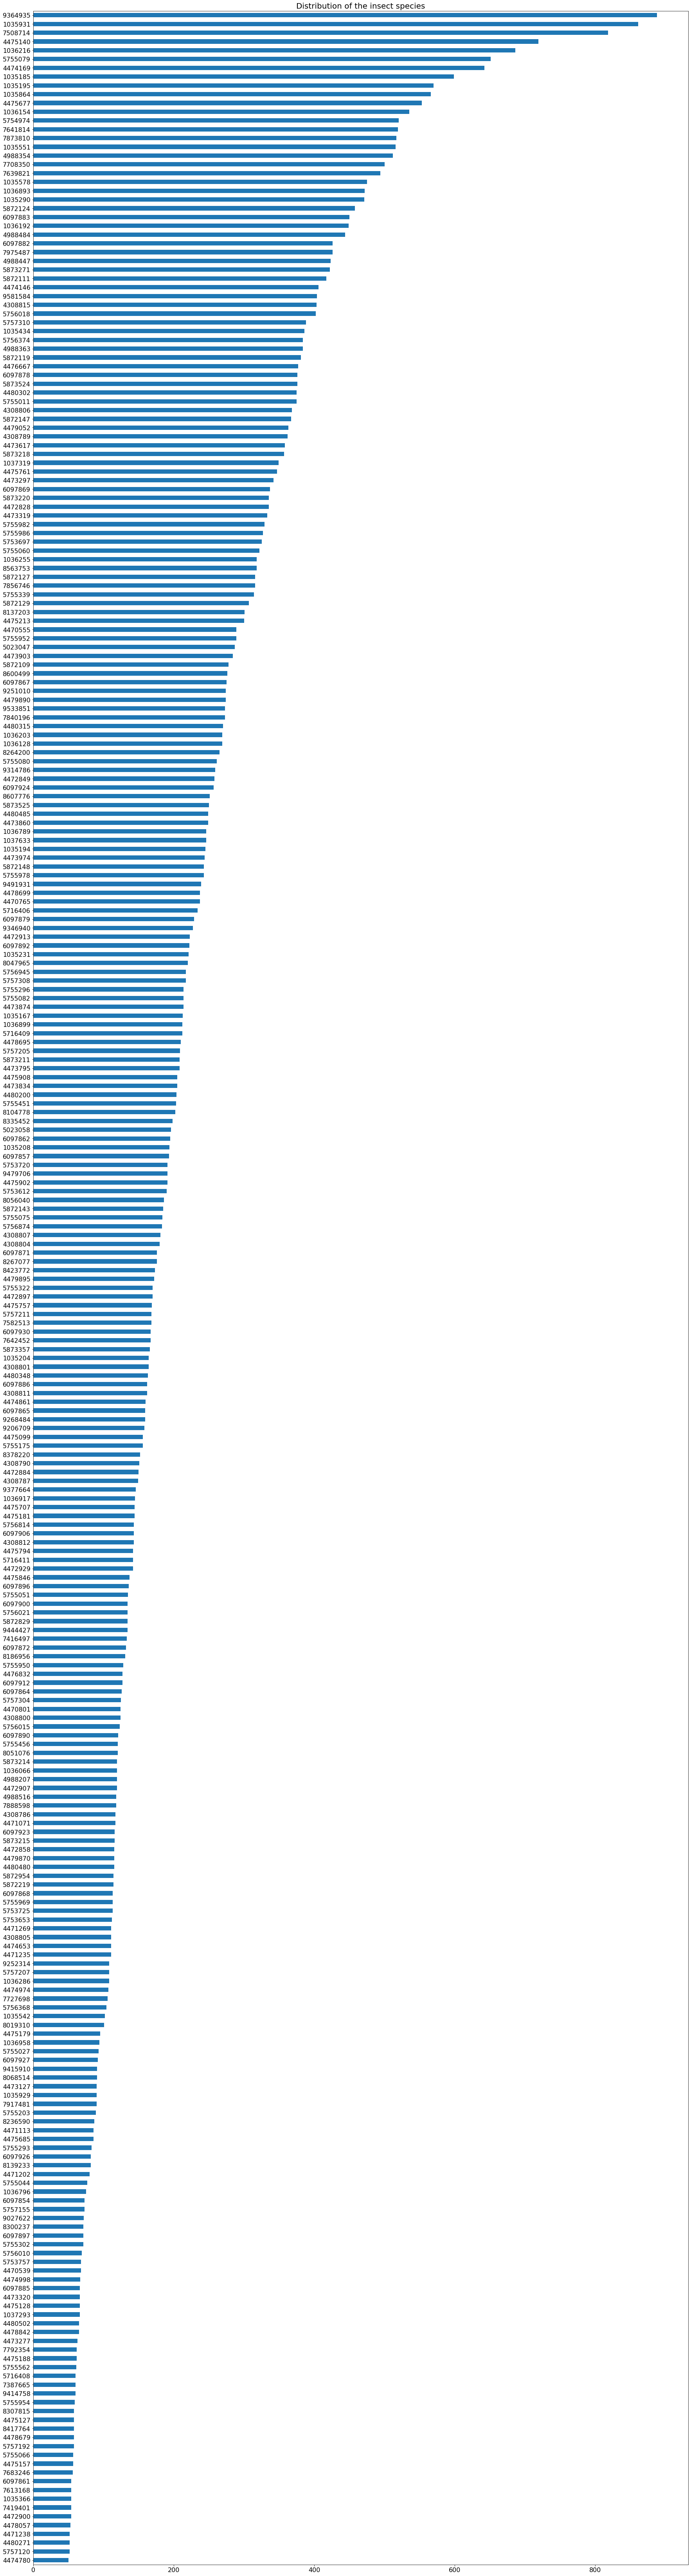

In [9]:
bar = df1["insect_gbif"].value_counts(ascending=True).plot.barh(figsize = (30,120))
plt.title("Distribution of the insect species", fontsize = 20)
bar.tick_params(labelsize=16)
plt.show()

lets also make a table.. may be better as there are 200+ species

In [10]:
df1["insect_gbif"].value_counts()

9364935    888
1035931    861
7508714    818
4475140    719
1036216    686
          ... 
4478057     53
4480271     52
4471238     52
5757120     52
4474780     50
Name: insect_gbif, Length: 291, dtype: int64

It is a very unbalanced data. Some insect species have only 50 images, while others have 888!

# Split data into test, train and validation

In [11]:
train, validate, test = np.split(df1.sample(frac=1), [int(.6*len(df1)), int(.8*len(df1))])

display(train.describe())
display(validate.describe())
display(test.describe())

,insect_gbif,path_img,file_name
count,38018,38018,38018
unique,291,38018,38018
top,1035931,C:/Users/tomas/Desktop/kaggle_kmldas_habitus/d...,7416497\d113s0136
freq,527,1,1


,insect_gbif,path_img,file_name
count,12673,12673,12673
unique,291,12673,12673
top,9364935,C:/Users/tomas/Desktop/kaggle_kmldas_habitus/d...,5872124\d087s0390
freq,183,1,1


,insect_gbif,path_img,file_name
count,12673,12673,12673
unique,291,12673,12673
top,9364935,C:/Users/tomas/Desktop/kaggle_kmldas_habitus/d...,5757310\d208s0019
freq,188,1,1


Some may prefer only test abd validation

you may combine two data sets- this will result in only train and validation set

comment or delete the below code if you want three sets of data

In [12]:
df=train.append(test, ignore_index=True)
df.describe()

,insect_gbif,path_img,file_name
count,50691,50691,50691
unique,291,50691,50691
top,9364935,C:/Users/tomas/Desktop/kaggle_kmldas_habitus/d...,7416497\d113s0136
freq,705,1,1


# Image Analysis

Let us display 20 picture of the dataset with their labels

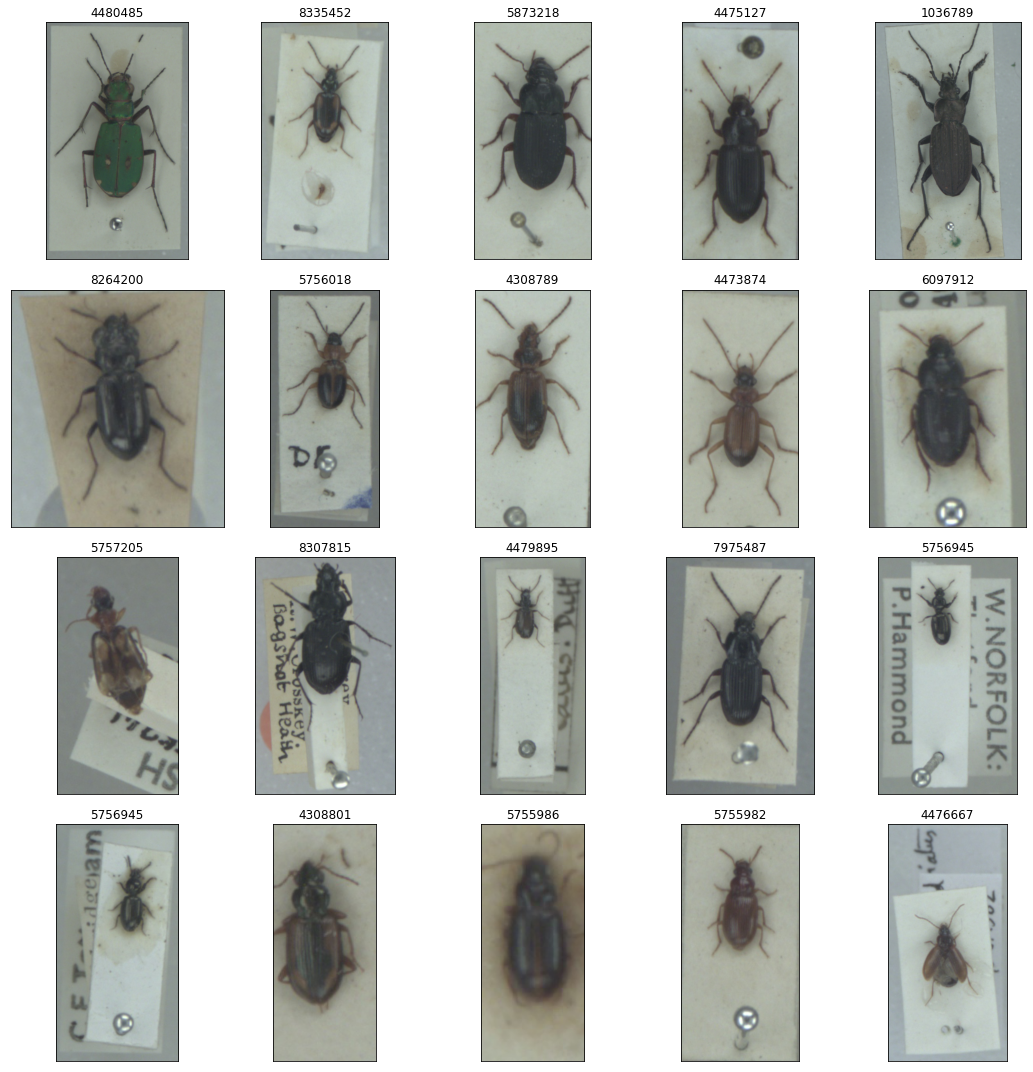

In [13]:
# Shuffle the dataset
from sklearn.utils import shuffle
df = shuffle(df, random_state = 0)
df = df.reset_index(drop=True)

# Display 20 picture of the dataset with their labels
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(15, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df.path_img[i]))
    ax.set_title(df.insect_gbif[i])
plt.tight_layout()
plt.show()

What do you observe?

All images are of differnt sizes

The backgrounsd vary a bit and as these are from a museum, there are the nals and other marks

# Image transforms using PyTorch

In [14]:
imagenet_stats = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) #normalisation

train_tfms = T.Compose([
#this will resize the image 
    T.Resize((256,256)),   
   
#Randomly change the brightness, contrast and saturation of an image
#    T.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),    

#this will remove parts (crop) the Image at a random location.   
#    T.RandomCrop(32, padding=4, padding_mode='reflect'),   

#Horizontally flip (rotate by 180 degree) the given image randomly; default is 50% of images
    T.RandomHorizontalFlip(), 
    
#Rotate the image by angle -here by 10%
    T.RandomRotation(10),
    
#convert it to a tensor   
    T.ToTensor(),

#Normalize a tensor image with mean and standard deviation - here with the Imagenet stats
    T.Normalize(*imagenet_stats,inplace=True)
    
#Randomly selects a rectangle region in an image and erases its pixels.    
#    T.RandomErasing(inplace=True)
])

val_tfms = T.Compose([
#this will resize the image 
    T.Resize((256,256)),   
     
#convert it to a tensor   
    T.ToTensor(),

#Normalize a tensor image with mean and standard deviation - here with the Imagenet stats
    T.Normalize(*imagenet_stats,inplace=True)
    
])

In [15]:
class InsectDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform
        
        
    def __len__(self):
        return len(self.df)    
    
    def __getitem__(self, idx):
        row = self.df.loc[idx]
        img_id, img_label = row['path_img'], row['insect_gbif']
        img = Image.open(img_id)
        if self.transform:
            img = self.transform(img)
        return img, img_label

In [16]:
train_ds = InsectDataset(train,transform=train_tfms)
val_ds = InsectDataset(validate, transform=val_tfms)
print("finished")

finished


In [17]:
def show_sample(img, target, invert=True):
    if invert:
        plt.imshow(1 - img.permute((1, 2, 0)))
    else:
        plt.imshow(img.permute(1, 2, 0))
    print('Labels:', target)

# View Sample Images after Transform

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Labels: 1035185


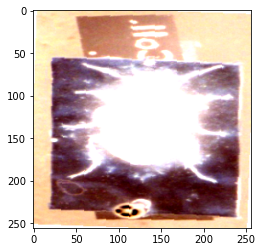

In [24]:
show_sample(*train_ds[269])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Labels: 1035185


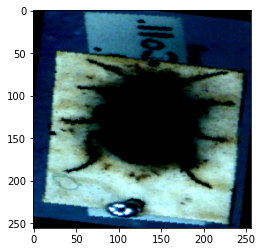

In [26]:
show_sample(*train_ds[269], invert= False)

# Lets GO!!

Lets make an image classification model! Hope this is a good starter for you!

Thanks and all the best!